# Santiago de Chile neighborhood analysis

## Introduction

Let's do a basic analysis between different Chilean neighborhoods within the Santiago City. The plan is to find which ones are similar between them, so a clustering algorithm will be used. 
In Santiago some neighborhoods are predominantly industrial, have tons of offices and restaurants to feed those workers, others are known for entertaiments with a wide variety of restaurants, bars and clubs, while others nught be mostly residentials.

## The Data

First, we need the Postal Codes of the neighborhoods of Santiago and we will scrap them from https://es.wikipedia.org/wiki/Anexo:C%C3%B3digos_postales_de_Chile, there is a table with every Postal Code of every neighborhood in Chile, so we will need to filter after the scrapping. Postal Codes between 7000000 and 8999999 correspond to nighborhoods inside the Metropolitan Area of Santiago, so we will use those.

Using geolocator library, we will get the Latitude and Longitude for every neighborhood and add them to the dataset, that way we hace the neighborhood with the associated coordinates.

With the Foursquare API, the venues of interest will be requested and added to a new dataframe, where they will be one hot encoded, grouped by neighborhood and standardized, so a clustering algorithm may be applied.

In [2]:
# Importing and installing every package needed.

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

!pip install geocoder
!pip install folium
!pip install geopy

# Library to handle JSON files
import json

# Convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# Library to handle requests
import requests

# Tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Import k-means from clustering stage
from sklearn.cluster import KMeans

# Map rendering library
import folium

In [101]:
# Web scrapping
req = requests.get("https://es.wikipedia.org/wiki/Anexo:C%C3%B3digos_postales_de_Chile")

soup = BeautifulSoup(req.content,'lxml')

table = soup.find_all('table')[0]

df = pd.read_html(str(table))

chile_pc = pd.DataFrame(df[0])

In [102]:
print('Dataset looks like this:')
chile_pc.head()

Dataset looks like this:


,Comuna/localidad,Código
0,Algarrobo,2710000
1,Alhué,9650000
2,Alto Biobío,4590000
3,Alto del Carmen,1650000
4,Alto Hospicio,1130000


In [103]:
print('Shape of the dataset:')
print(chile_pc.shape)

#renaming columns
chile_pc = chile_pc.rename(columns={'Comuna/localidad' : 'Neighborhood', 'Código' : 'PostalCode'})

#filtering columns and reseting index
chile_pc = chile_pc[(chile_pc['PostalCode']>= 7000000) & (chile_pc['PostalCode']<= 8999999)]
chile_pc = chile_pc.reset_index(drop=True)

chile_pc

Shape of the dataset:
(344, 2)


,Neighborhood,PostalCode
0,Conchalí,8540000
1,El Bosque,8010000
2,Huechuraba,8580000
3,Independencia,8380000
4,La Cisterna,7970000
5,La Florida,8240000
6,La Granja,8780000
7,La Pintana,8820000
8,La Reina,7850000
9,Las Condes,7550000


In [104]:
# Make a list with all the neighborhoods name
list_of_nh = chile_pc['Neighborhood'].to_list()

# Add a CL to the neighborhood name, but is that neighborhood is Santiago, then add a CH
# This is for finding latitude and longitude with Geolocator Nominatim, and for some reason 'Santiago, CL' does not find the correct coordinates, but 'Santiago, CH does'
for i in range(0,len(list_of_nh)):
    if list_of_nh[i] == 'Santiago':
        chile_pc.at[i,'Neighborhood'] = list_of_nh[i] + ', CH'
    else:
        chile_pc.at[i,'Neighborhood'] = list_of_nh[i] + ', CL'
        
print('Resulting Dataset:')
chile_pc

Resulting Dataset:


,Neighborhood,PostalCode
0,"Conchalí, CL",8540000
1,"El Bosque, CL",8010000
2,"Huechuraba, CL",8580000
3,"Independencia, CL",8380000
4,"La Cisterna, CL",7970000
5,"La Florida, CL",8240000
6,"La Granja, CL",8780000
7,"La Pintana, CL",8820000
8,"La Reina, CL",7850000
9,"Las Condes, CL",7550000


In [105]:
# Making empty lists for latitude and longitude
lat_list=[]
lon_list=[]

# Updating list with name of all neighborhoods fot geolocator search
list_of_nh = chile_pc['Neighborhood'].to_list()

# Getting every neighborhood's coordinates and adding them to they respective coordinates
# Printing both coordinates and lists to make sure they are correct and saved in the lists
for i in list_of_nh:
    address = i
    geolocator = Nominatim(user_agent="santiago_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of ', i, ' are {}, {}.'.format(latitude, longitude))
    lat_list.append(latitude)
    lon_list.append(longitude)
    
print('\n', 'Latitude List:', lat_list)
print('\n', 'Longitude List', lon_list)

The geograpical coordinate of  Conchalí, CL  are -33.384775149999996, -70.67460576456799.
The geograpical coordinate of  El Bosque, CL  are -33.56235185, -70.67681955928742.
The geograpical coordinate of  Huechuraba, CL  are -33.365721449999995, -70.6429271186091.
The geograpical coordinate of  Independencia, CL  are -33.416411749999995, -70.66581795393661.
The geograpical coordinate of  La Cisterna, CL  are -33.5295218, -70.66425289405431.
The geograpical coordinate of  La Florida, CL  are -33.530714450000005, -70.54402715938959.
The geograpical coordinate of  La Granja, CL  are -33.53587875, -70.62229522259899.
The geograpical coordinate of  La Pintana, CL  are -33.591388550000005, -70.63642326010053.
The geograpical coordinate of  La Reina, CL  are -33.44737295, -70.53341181233888.
The geograpical coordinate of  Las Condes, CL  are -33.4247879, -70.51749760753927.
The geograpical coordinate of  Lo Barnechea, CL  are -33.2935888, -70.39035501440654.
The geograpical coordinate of  Lo 

In [106]:
# Adding the Latitude and Longitude to the dataframe using the created lists
chile_pc['Latitude'] = lat_list
chile_pc['Longitude'] = lon_list

print('Resulting Dataset:')
chile_pc

Resulting Dataset:


,Neighborhood,PostalCode,Latitude,Longitude
0,"Conchalí, CL",8540000,-33.384775,-70.674606
1,"El Bosque, CL",8010000,-33.562352,-70.676820
2,"Huechuraba, CL",8580000,-33.365721,-70.642927
3,"Independencia, CL",8380000,-33.416412,-70.665818
4,"La Cisterna, CL",7970000,-33.529522,-70.664253
5,"La Florida, CL",8240000,-33.530714,-70.544027
6,"La Granja, CL",8780000,-33.535879,-70.622295
7,"La Pintana, CL",8820000,-33.591389,-70.636423
8,"La Reina, CL",7850000,-33.447373,-70.533412
9,"Las Condes, CL",7550000,-33.424788,-70.517498


In [107]:
# Create map of Santiago City centered in the Santiago neighborhood
latitude = chile_pc.at[26,'Latitude']
longitude = chile_pc.at[26,'Longitude']
map_stgo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(chile_pc['Latitude'], chile_pc['Longitude'], chile_pc['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stgo)  
    
map_stgo

Las Condes, Lo Barnechea, Peñalolén and La Florida seem very far away, because those are incredibly huge municipalities they centers will look like outside or on the border of the city.

I will move all of them manually, so the map makes sense. I will use each neighborhood Municipality building as new center point.

In [108]:
address = i
geolocator = Nominatim(user_agent="santiago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
lat_list.append(latitude)
lon_list.append(longitude)

In [110]:
# Updating La Florida coordinates to the Lo Barnechea Municipality
chile_pc.at[5,'Latitude'] = -33.5587812
chile_pc.at[5,'Longitude'] = -70.5891141

# Updating Las Condes coordinates to the Las Condes Municipality
chile_pc.at[9,'Latitude'] = -33.4079488
chile_pc.at[9,'Longitude'] = -70.5451132

# Updating Lo Barnechea coordinates to the Lo Barnechea Municipality
chile_pc.at[10,'Latitude'] = -33.3534679
chile_pc.at[10,'Longitude'] = -70.5222244

# Updating Peñalolén coordinates to the Lo Barnechea Municipality
chile_pc.at[15,'Latitude'] = -33.4764817
chile_pc.at[15,'Longitude'] = -70.5445814

In [111]:
chile_pc

,Neighborhood,PostalCode,Latitude,Longitude
0,"Conchalí, CL",8540000,-33.384775,-70.674606
1,"El Bosque, CL",8010000,-33.562352,-70.676820
2,"Huechuraba, CL",8580000,-33.365721,-70.642927
3,"Independencia, CL",8380000,-33.416412,-70.665818
4,"La Cisterna, CL",7970000,-33.529522,-70.664253
5,"La Florida, CL",8240000,-33.558781,-70.589114
6,"La Granja, CL",8780000,-33.535879,-70.622295
7,"La Pintana, CL",8820000,-33.591389,-70.636423
8,"La Reina, CL",7850000,-33.447373,-70.533412
9,"Las Condes, CL",7550000,-33.407949,-70.545113


In [112]:
# Create map of Santiago City centered in the Santiago neighborhood
latitude = chile_pc.at[26,'Latitude']
longitude = chile_pc.at[26,'Longitude']
map_stgo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(chile_pc['Latitude'], chile_pc['Longitude'], chile_pc['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stgo)  
    
map_stgo

Now that the locations are fixed, we can continue

In [113]:
#@hidden_cell
# Foursquare credentials
CLIENT_ID = 'JZGYNFOYT4J24NPR5XYHN1OFOHA53FG1J1VXG43JS1MDW0PO' # your Foursquare ID
CLIENT_SECRET = '20JWSCGWU5MV0LQOPTPGGB2LCPMBMLKHFHGXFG0AHPDWXZ00' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [114]:
# Funtion to get nearby venues
LIMIT = 1000 # Limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=1800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [115]:
# Get nearby venues for Santiago
santiago_venues = getNearbyVenues(names=chile_pc['Neighborhood'],
                                   latitudes=chile_pc['Latitude'],
                                   longitudes=chile_pc['Longitude'],
                                   radius=1800
                                  )

Conchalí, CL
El Bosque, CL
Huechuraba, CL
Independencia, CL
La Cisterna, CL
La Florida, CL
La Granja, CL
La Pintana, CL
La Reina, CL
Las Condes, CL
Lo Barnechea, CL
Lo Prado, CL
Macul, CL
Ñuñoa, CL
Pedro Aguirre Cerda, CL
Peñalolén, CL
Providencia, CL
Puente Alto, CL
Quilicura, CL
Quinta Normal, CL
Recoleta, CL
Renca, CL
San Bernardo, CL
San Joaquín, CL
San Miguel, CL
San Ramón, CL
Santiago, CH
Vitacura, CL


In [116]:
# Check the created dataframe
print(santiago_venues.shape)
santiago_venues.head()

(1594, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Conchalí, CL",-33.384775,-70.674606,El Gordo,-33.380691,-70.682709,Restaurant
1,"Conchalí, CL",-33.384775,-70.674606,Restaurant Sing Hwa,-33.389565,-70.675896,Chinese Restaurant
2,"Conchalí, CL",-33.384775,-70.674606,La Pierna,-33.392688,-70.676679,Sandwich Place
3,"Conchalí, CL",-33.384775,-70.674606,Gimnasio BodyPalace Gym,-33.386052,-70.679963,Gym
4,"Conchalí, CL",-33.384775,-70.674606,Bar Rebelión,-33.395033,-70.672267,Pub


In [117]:
# Check how many per neighborhood
santiago_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Conchalí, CL",25,25,25,25,25,25
"El Bosque, CL",22,22,22,22,22,22
"Huechuraba, CL",17,17,17,17,17,17
"Independencia, CL",71,71,71,71,71,71
"La Cisterna, CL",61,61,61,61,61,61
"La Florida, CL",61,61,61,61,61,61
"La Granja, CL",11,11,11,11,11,11
"La Pintana, CL",9,9,9,9,9,9
"La Reina, CL",59,59,59,59,59,59


In [118]:
# Check how many unique categories
print('There are {} uniques categories.'.format(len(santiago_venues['Venue Category'].unique())))

There are 228 uniques categories.


In [119]:
# one hot encoding
santiago_onehot = pd.get_dummies(santiago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
santiago_onehot['Neighborhood'] = santiago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [santiago_onehot.columns[-1]] + list(santiago_onehot.columns[:-1])
santiago_onehot = santiago_onehot[fixed_columns]

santiago_onehot.head()

,Zoo Exhibit,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
# Check shape
santiago_onehot.shape

(1594, 228)

In [121]:
# group by neighborhood and use the mean of occurrence for each type of venue
santiago_grouped = santiago_onehot.groupby('Neighborhood').mean().reset_index()
santiago_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,"Conchalí, CL",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.04,0.000000,0.000,0.00
1,"El Bosque, CL",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.045455,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00
2,"Huechuraba, CL",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00
3,"Independencia, CL",0.000000,0.00,0.000000,0.000000,0.014085,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.000000,0.014085,0.00,0.000000,0.00,0.000000,0.000,0.00
4,"La Cisterna, CL",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00
5,"La Florida, CL",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00
6,"La Granja, CL",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00
7,"La Pintana, CL",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00
8,"La Reina, CL",0.016949,0.00,0.033898,0.016949,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00
9,"Las Condes, CL",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.00,...,0.00,0.010000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.01


In [122]:
# top 5 venue types per neighborhood
num_top_venues = 5

for hood in santiago_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = santiago_grouped[santiago_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Conchalí, CL----
                venue  freq
0            Pharmacy  0.12
1          Food Truck  0.08
2      Sandwich Place  0.08
3                Park  0.08
4  Chinese Restaurant  0.08


----El Bosque, CL----
          venue  freq
0   Flea Market  0.14
1         Plaza  0.09
2  Liquor Store  0.09
3           Bar  0.05
4  Burger Joint  0.05


----Huechuraba, CL----
                venue  freq
0   Electronics Store  0.12
1       Internet Cafe  0.06
2  Miscellaneous Shop  0.06
3   Convenience Store  0.06
4            Pharmacy  0.06


----Independencia, CL----
                venue  freq
0          Restaurant  0.07
1  Chinese Restaurant  0.06
2                Park  0.04
3      Farmers Market  0.04
4                Café  0.04


----La Cisterna, CL----
                venue  freq
0  Chinese Restaurant  0.13
1            Pharmacy  0.10
2    Sushi Restaurant  0.10
3         Pizza Place  0.08
4       Grocery Store  0.05


----La Florida, CL----
                  venue  freq
0    Chinese Rest

In [123]:
# function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [124]:
#new dataframe with top 10 venues per neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = santiago_grouped['Neighborhood']

for ind in np.arange(santiago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(santiago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Conchalí, CL",Pharmacy,Sandwich Place,Food Truck,Chinese Restaurant,Park,Farmers Market,Fried Chicken Joint,Stadium,Restaurant,Fast Food Restaurant
1,"El Bosque, CL",Flea Market,Liquor Store,Plaza,Ice Cream Shop,Pharmacy,Pizza Place,Department Store,Bus Station,Burger Joint,Shopping Mall
2,"Huechuraba, CL",Electronics Store,Internet Cafe,Bakery,Convenience Store,Plaza,Coffee Shop,Chinese Restaurant,Restaurant,Outdoors & Recreation,Cafeteria
3,"Independencia, CL",Restaurant,Chinese Restaurant,Peruvian Restaurant,Park,Sandwich Place,Café,Farmers Market,Sushi Restaurant,Plaza,Fast Food Restaurant
4,"La Cisterna, CL",Chinese Restaurant,Sushi Restaurant,Pharmacy,Pizza Place,Grocery Store,Bakery,Park,Burger Joint,Bar,Fast Food Restaurant
5,"La Florida, CL",Chinese Restaurant,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Bakery,Restaurant,Japanese Restaurant,Nightclub,Food Truck,Liquor Store
6,"La Granja, CL",Pharmacy,Business Service,Food,Flea Market,Shopping Mall,Farmers Market,Basketball Court,Bakery,Salad Place,Chinese Restaurant
7,"La Pintana, CL",Park,Soccer Stadium,Sushi Restaurant,Pharmacy,Plaza,Event Service,Tourist Information Center,Farmers Market,Event Space,Falafel Restaurant
8,"La Reina, CL",Chinese Restaurant,Pizza Place,Restaurant,Soccer Field,Bakery,Big Box Store,Event Space,Bus Station,Café,Plaza
9,"Las Condes, CL",Sushi Restaurant,Plaza,Coffee Shop,Stadium,Pizza Place,Restaurant,Bakery,Motorcycle Shop,Chinese Restaurant,Arts & Crafts Store


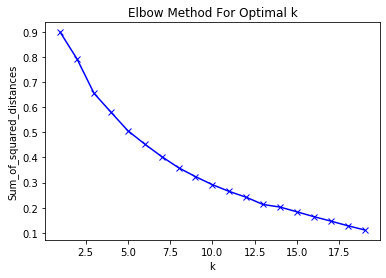

In [125]:
#Checking best K
Sum_of_squared_distances = []
santiago_grouped_clustering = santiago_grouped.drop('Neighborhood', 1)
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(santiago_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [126]:
#Start the clustering

# set number of clusters
kclusters = 8

santiago_grouped_clustering = santiago_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(santiago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([5, 6, 7, 0, 5, 5, 4, 3, 0, 2, 2, 5, 5, 0, 0, 2, 0, 0, 5, 2, 1, 0,
       2, 0, 0, 2, 2, 2])

In [127]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
santiago_merged = chile_pc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
santiago_merged = santiago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

santiago_merged # check the last columns!

,Neighborhood,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Conchalí, CL",8540000,-33.384775,-70.674606,5,Pharmacy,Sandwich Place,Food Truck,Chinese Restaurant,Park,Farmers Market,Fried Chicken Joint,Stadium,Restaurant,Fast Food Restaurant
1,"El Bosque, CL",8010000,-33.562352,-70.676820,6,Flea Market,Liquor Store,Plaza,Ice Cream Shop,Pharmacy,Pizza Place,Department Store,Bus Station,Burger Joint,Shopping Mall
2,"Huechuraba, CL",8580000,-33.365721,-70.642927,7,Electronics Store,Internet Cafe,Bakery,Convenience Store,Plaza,Coffee Shop,Chinese Restaurant,Restaurant,Outdoors & Recreation,Cafeteria
3,"Independencia, CL",8380000,-33.416412,-70.665818,0,Restaurant,Chinese Restaurant,Peruvian Restaurant,Park,Sandwich Place,Café,Farmers Market,Sushi Restaurant,Plaza,Fast Food Restaurant
4,"La Cisterna, CL",7970000,-33.529522,-70.664253,5,Chinese Restaurant,Sushi Restaurant,Pharmacy,Pizza Place,Grocery Store,Bakery,Park,Burger Joint,Bar,Fast Food Restaurant
5,"La Florida, CL",8240000,-33.558781,-70.589114,5,Chinese Restaurant,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Bakery,Restaurant,Japanese Restaurant,Nightclub,Food Truck,Liquor Store
6,"La Granja, CL",8780000,-33.535879,-70.622295,4,Pharmacy,Business Service,Food,Flea Market,Shopping Mall,Farmers Market,Basketball Court,Bakery,Salad Place,Chinese Restaurant
7,"La Pintana, CL",8820000,-33.591389,-70.636423,3,Park,Soccer Stadium,Sushi Restaurant,Pharmacy,Plaza,Event Service,Tourist Information Center,Farmers Market,Event Space,Falafel Restaurant
8,"La Reina, CL",7850000,-33.447373,-70.533412,0,Chinese Restaurant,Pizza Place,Restaurant,Soccer Field,Bakery,Big Box Store,Event Space,Bus Station,Café,Plaza
9,"Las Condes, CL",7550000,-33.407949,-70.545113,2,Sushi Restaurant,Plaza,Coffee Shop,Stadium,Pizza Place,Restaurant,Bakery,Motorcycle Shop,Chinese Restaurant,Arts & Crafts Store


In [128]:
# Create map of Santiago City centered in the Santiago neighborhood
latitude = chile_pc.at[26,'Latitude']
longitude = chile_pc.at[26,'Longitude']
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(santiago_merged['Latitude'], santiago_merged['Longitude'], santiago_merged['Neighborhood'], santiago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters